## Multivariable Regression

### Prepared by Robin Fladebo     December 2018

### Introduction

Prepare FBI Uniform Crime Reporting data, for the State of New York for 2013, for use in a model with multivariable regression (including data cleaning if necessary) according to this specification:

Propertycrime=α+Population+Population^2+Murder+Robbery

The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. Don't forget basic data cleaning procedures. Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

#### Notes on data content

Property crime includes burglary, larceny-theft and vehicle theft.
Data can be retrieved here: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

Violent crime includes murder, non-negligent homicide, rape, robbery and aggravated assault.

### Data preparation

In [356]:
import warnings
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline
import seaborn as sns

In [357]:
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [358]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [359]:
df = pd.read_excel('../Datafiles/fbi_nyxcity_2013.xlsx',sheet_name='fbi_nyxcity_2013')
df_test = pd.read_excel('../Datafiles/fbi_nyxcity_2017.xlsx',sheet_name='fbi_nyxcity_2017')

In [360]:
df.rename(columns=lambda x: x.replace('\n', '_'), inplace=True)
df_test.rename(columns=lambda x: x.replace('\n', '_'), inplace=True)

In [361]:
df.rename(columns=lambda x: x.lower(), inplace=True)
df_test.rename(columns=lambda x: x.lower(), inplace=True)

In [362]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def'}, inplace=True)
df_test.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def'}, inplace=True)

In [363]:
df.rename(columns={'murder and_nonnegligent_manslaughter':'murder'}, inplace=True)
df_test.rename(columns={'murder and_nonnegligent_manslaughter':'murder'}, inplace=True)

In [364]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def', 'larceny-_theft':'larceny_theft'}, inplace=True)
df_test.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def', 'larceny-_theft':'larceny_theft'}, inplace=True)

In [365]:
# Drop any column that is filled with NA values
df.dropna(how='all', axis=1, inplace=True)
df_test.dropna(how='all', axis=1, inplace=True)

In [366]:
# Keep rows with at least 2 non-NA values (i.e., drop Notes rows)
df.dropna(how='any', thresh=2, inplace=True)
df_test.dropna(how='any', thresh=2, inplace=True)

In [367]:
df.drop(df[df['property_crime'] == 0].index, inplace=True)
df_test.drop(df_test[df_test['property_crime'] == 0].index, inplace=True)

Create new features

In [368]:
df['pop_log'] = np.log(df['population'])
df_test['pop_log'] = np.log(df_test['population'])

In [369]:
df['pty_crime_log'] = np.log(df['property_crime'])
df_test['pty_crime_log'] = np.log(df_test['property_crime'])

In [370]:
def set_ind(var,new_val):
    df[new_val]=np.where(df[var]>0, 1, 0)
    return df
df = set_ind('murder', 'murder_ind')
df = set_ind('robbery', 'robbery_ind')

In [371]:
def set_ind_t(var_t,new_val_t):
    df_test[new_val_t]=np.where(df_test[var_t]>0, 1, 0)
    return df_test
df_test = set_ind_t('murder', 'murder_ind')
df_test = set_ind_t('robbery', 'robbery_ind')

In [372]:
df['qrtl_1']=np.where(df['population']<3004, 1, 0)
df['qrtl_2']=np.where((df['population']>3003) & (df['population']<7234), 1, 0)
df['qrtl_3']=np.where((df['population']>7233) & (df['population']<184270), 1, 0)
df['qrtl_4']=np.where(df['population']>184271, 1, 0)
df_test['qrtl_1']=np.where(df_test['population']<3004, 1, 0)
df_test['qrtl_2']=np.where((df_test['population']>3003) & (df_test['population']<7234), 1, 0)
df_test['qrtl_3']=np.where((df_test['population']>7233) & (df_test['population']<184270), 1, 0)
df_test['qrtl_4']=np.where(df_test['population']>184271, 1, 0)

### Running the model on two datasets

In [373]:
df_m6 = df.filter(['population', 'pop_log','murder_ind','robbery_ind', 'pty_crime_log', 'property_crime', 'qrtl_1', 'qrtl_4'])
df_m6_t = df_test.filter(['population', 'pop_log','murder_ind','robbery_ind', 'pty_crime_log', 'property_crime', 'qrtl_1', 'qrtl_4'])

The training set (2013 data)

In [374]:
m6 = linear_model.LinearRegression()
Y = df_m6['pty_crime_log'].values.reshape(-1, 1)
X = df_m6[['pop_log','murder_ind', 'robbery_ind', 'qrtl_4']]
m6.fit(X, Y)

print('\nCoefficients: \n', m6.coef_)
print('\nIntercept: \n', m6.intercept_)
print('\nR-squared:')
print(m6.score(X, Y))


Coefficients: 
 [[0.89506238 0.28601834 0.88751512 0.41483977]]

Intercept: 
 [-3.84769376]

R-squared:
0.8037651400654878


The test set (2017 data)

m6_t = linear_model.LinearRegression()
Y = df_m6_t['pty_crime_log'].values.reshape(-1, 1)
X = df_m6_t[['pop_log','murder_ind', 'robbery_ind', 'qrtl_4']]
m6_t.fit(X, Y)

print('\nCoefficients: \n', m6_t.coef_)
print('\nIntercept: \n', m6_t.intercept_)
print('\nR-squared:')
print(m6_t.score(X, Y))

### Model statistics

In [376]:
linear_formula = 'pty_crime_log ~ pop_log+murder_ind+robbery_ind+qrtl_4'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_m6).fit()

In [377]:
lm.params

Intercept     -3.847694
pop_log        0.895062
murder_ind     0.286018
robbery_ind    0.887515
qrtl_4         0.414840
dtype: float64

In [378]:
lm.pvalues

Intercept      7.580649e-22
pop_log        4.066809e-58
murder_ind     2.904965e-02
robbery_ind    2.955388e-17
qrtl_4         3.023886e-01
dtype: float64

In [379]:
lm.rsquared

0.8037651400654878

In [380]:
lm.conf_int()

,0,1
Intercept,-4.581749,-3.113638
pop_log,0.805797,0.984328
murder_ind,0.029377,0.542660
robbery_ind,0.691872,1.083158
qrtl_4,-0.375166,1.204845


The qrtl_4 value is not statistically significant.

In [381]:
lm.fvalue


345.08248469775475

In [382]:
lm.f_pvalue

9.283395965210341e-118

Show confidence intervals graphically

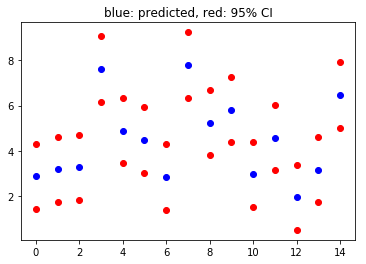

In [383]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

In [384]:
linear_formula2 = 'pty_crime_log ~ pop_log+murder_ind+robbery_ind'

# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula2, data=df_m6).fit()

In [385]:
lm2.rsquared

0.8031438881167701

In [386]:
lm2.conf_int()

,0,1
Intercept,-4.667526,-3.280103
pop_log,0.826365,0.994825
murder_ind,0.044707,0.555270
robbery_ind,0.677261,1.062907


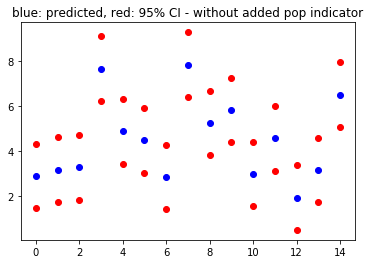

In [387]:
prstd, iv_l, iv_u = wls_prediction_std(lm2)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm2.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI - without added pop indicator')
plt.show()

In [391]:
lm_t = smf.ols(formula=linear_formula2, data=df_m6_t).fit()

In [392]:
lm_t.rsquared

0.779033346385718

In [393]:
lm_t.conf_int()

,0,1
Intercept,-5.688654,-4.077578
pop_log,0.858152,1.058763
murder_ind,0.265706,0.860285
robbery_ind,0.627433,1.120523


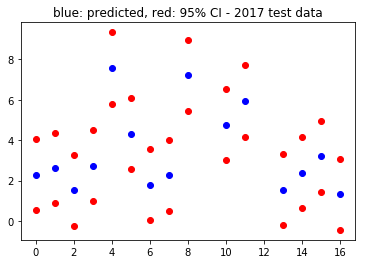

In [395]:
prstd, iv_l, iv_u = wls_prediction_std(lm_t)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm_t.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI - 2017 test data')
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# # Use train_test_split to create the necessary training and test groups
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
# print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
# print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

In [ ]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(m6, data, target, cv=10)